In [ ]:
!pip3 install git+https://github.com/dskoda/Atomistic-Adversarial-Attacks.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/dskoda/Atomistic-Adversarial-Attacks.git to /tmp/pip-req-build-hv7yppae
  Running command git clone --filter=blob:none --quiet https://github.com/dskoda/Atomistic-Adversarial-Attacks.git /tmp/pip-req-build-hv7yppae
  Resolved https://github.com/dskoda/Atomistic-Adversarial-Attacks.git to commit 441aea4c866e253ab5e895fd8157dcd9159b7503
  Preparing metadata (setup.py) ... done
  Created wheel for AtomAttacks: filename=AtomAttacks-1.0-py3-none-any.whl size=24041 sha256=1f0cd117efc93bc28bdd40674605a8f416e5b0fb7bc6f701891c393000be80fc
  Stored in directory: /tmp/pip-ephem-wheel-cache-_3ig7ud4/wheels/ba/94/37/3cb5029ce22f1d452e740e6b5c30991e7e81ae9e6fa4cb9e3e
Successfully built AtomAttacks


# Adversarial attacks on 2D double well potential

In this notebook, we reproduce the example of adversarial attacks on the asymetric 2D double well shown in Fig. 2 of the [Atomistic Adversarial Attacks paper](https://doi.org/10.1038/s41467-021-25342-8).

The notebook uses the models and the helper functions in the `robust` folder of the [repo](https://github.com/dskoda/Atomistic-Adversarial-Attacks.git).

In [ ]:
import robust as rb
from robust.pipeline import ForwardPipeline
from robust.loop import ActiveLearning
import torch as ch
import numpy as np

from scipy import stats

from matplotlib import cm
import matplotlib.pyplot as plt

## Creating the 2D double well

Using the potentials available at the `robust` module, we created an asymetric 1D double well with the desired zeros, depth and offset. In particular, the equation for the potential is the following:

$$E(x, y) = 10 x^4 - 10 x^2 + 2x + 4 y^2$$

Then, the `potential` object creates the training set, the `true_potential` is used for the evaluation (e.g. the surrogate model, or analogous to a FF or DFT calculation). We also select the plotting range for the potentials, in order to achieve a better visualization for this work.

In [ ]:
AX = 10
BX = 1
CX = 2
AY = 4
BY = 0
CY = 0

ENERGY_THRESHOLD = -2

potential = rb.potentials.Masked2DDoubleWell(
    ax=AX, bx=BX, cx=CX,
    ay=AY, by=BY, cy=CY,    
    emax=ENERGY_THRESHOLD,
    energy_noise=0.0,
)

true_potential = rb.potentials.TwoDimensionalDoubleWell(
    ax=AX, bx=BX, cx=CX,
    ay=AY, by=BY, cy=CY,
)

In [ ]:
PLOT_RANGE = 1.2
STEPS = 300

x = np.linspace(-PLOT_RANGE, PLOT_RANGE, STEPS)
y = np.linspace(-PLOT_RANGE, PLOT_RANGE, STEPS)

SHAPE = (len(x), len(y))

X, Y = np.meshgrid(x, y)
XY = np.stack([X.reshape(-1), Y.reshape(-1)], axis=1)
XY = ch.tensor(XY).to(ch.float32)

dplot = rb.PotentialDataset(*true_potential(XY))

/usr/local/lib/python3.8/dist-packages/robust/data.py:76: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return ch.tensor(tensor).reshape(len(tensor), -1)
/usr/local/lib/python3.8/dist-packages/robust/data.py:77: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return ch.tensor(tensor)


In [ ]:
xytrain = (2 * ch.rand(800, 2) - 1) * PLOT_RANGE
dset = rb.PotentialDataset(*potential(xytrain))

Now we can just visualize the training set (white dots) and the toy potential

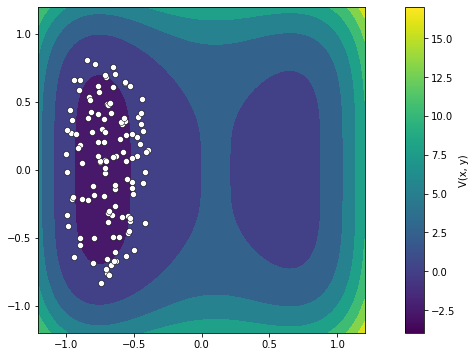

In [ ]:
Z = dplot.e.reshape(X.shape).numpy()

cmap = cm.get_cmap("viridis")
norm = cm.colors.Normalize(vmin=np.min(Z), vmax=np.max(Z))
scalarMap = cm.ScalarMappable(norm=norm, cmap=cmap)
c = scalarMap.to_rgba(Z)

fig, (ax, cax) = plt.subplots(1, 2, figsize=(7, 6), gridspec_kw={'width_ratios': (0.9, 0.05)})

ax.contourf(X, Y, Z, cmap=cmap)

xtrain, ytrain = dset.x[:, 0], dset.x[:, 1]
ax.scatter(xtrain, ytrain, c='w', linewidths=0.5, edgecolors='k')
ax.set_aspect('equal')

cbar = fig.colorbar(scalarMap, shrink=.65, cax=cax, orientation='vertical')
cbar.set_label('V(x, y)')

plt.show()

## Training the models

Now, we select all hyperparameters of the models. The NN ensemble is generated from the `model_params`. The `loss_params` are used both for the training and adversarial loss, although the latter uses only the temperature. `score_params` uses some deduplication strategies, as explained in Sec. II-C of the paper. Afterwards, the initial pipeline (i.e. one loop cycle) is created, and the model is trained.

In [ ]:
loss_params = {
    'energy_coef': 1,
    'forces_coef': 10,
    'temperature': 5,
}

model_params = {
    'input_dim': 2,
    'output_dim': 1,
    'num_layers': 4,
    'layer_dim': 1024,
    'num_networks': 5
}

optim_params = {
    'lr': 1e-3,
}

train_params = {
    'max_epochs': 500,
    'batch_size': 35,
}

attack_params = {
    'delta_std': 1e-2,
    'optim_kws': {'lr': 3e-3},
}

score_params = {
    'UncertaintyPercentile': {'percentile': 80},
}

prefix = 'models_2D'

DEVICE = "cuda"

In [ ]:
pipeline = ForwardPipeline(
    dset,
    model_params,
    loss_params,
    optim_params,
    train_params,
    attack_params,
    name=f'{prefix}/gen_1',
)

In [ ]:
loop = ActiveLearning(
    pipeline,
    true_potential,
    device=DEVICE,
    train_epochs=200,
    attack_epochs=400,
    scores=score_params,
    num_generations=4,
    name_prefix=prefix,
)

In [ ]:
loop.loop()

ACT_LEARN: GEN 1: training model
 Time | Epoch | Learning rate | Train loss | Validation loss | MAE Energy | MAE Forces | GPU Memory (MB)
35:26 |   125 |     1.000e-03 |    22.3111 |         24.3912 |     0.9747 |     6.3738 |             168
35:27 |   150 |     1.000e-03 |    17.1581 |         14.8746 |     1.0578 |     5.0927 |             168
35:29 |   175 |     1.000e-03 |     7.7996 |         10.1619 |     0.8006 |     3.5176 |             168
35:30 |   200 |     1.000e-03 |     7.4373 |          9.8602 |     0.8254 |     3.3278 |             168
35:31 |   225 |     1.000e-03 |     7.4700 |          9.8655 |     0.7086 |     3.3524 |             168
35:32 |   250 |     1.000e-03 |     7.5064 |          9.8746 |     1.0129 |     3.1292 |             168
35:33 |   275 |     1.000e-03 |     7.1504 |          9.7534 |     0.8456 |     3.3041 |             168
35:34 |   300 |     1.000e-03 |     7.3394 |         10.2561 |     0.8116 |     3.5682 |             168
ACT_LEARN: GEN 1: eval

## Plotting the evolution of the active learning loop

This plot reproduces Fig. 2a of the paper, up to differences due to random initialization. It essentially shows all adversarial attacks and the evolution of the uncertainty/loss across generations.

/usr/local/lib/python3.8/dist-packages/robust/data.py:76: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return ch.tensor(tensor).reshape(len(tensor), -1)
/usr/local/lib/python3.8/dist-packages/robust/data.py:77: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return ch.tensor(tensor)
<ipython-input-15-0d6b61af0297>:16: UserWarning: The following kwargs were not used by contour: 'label'
  ax.contourf(
<ipython-input-15-0d6b61af0297>:28: UserWarning: The following kwargs were not used by contour: 'label'
  ax.contourf(
<ipython-input-15-0d6b61af0297>:70: UserWarning: The following kwargs were not used by contour: 'label'
  ax.contourf(
<ipython-input-15-0d6b61af0297>:115: UserWarning: The fo

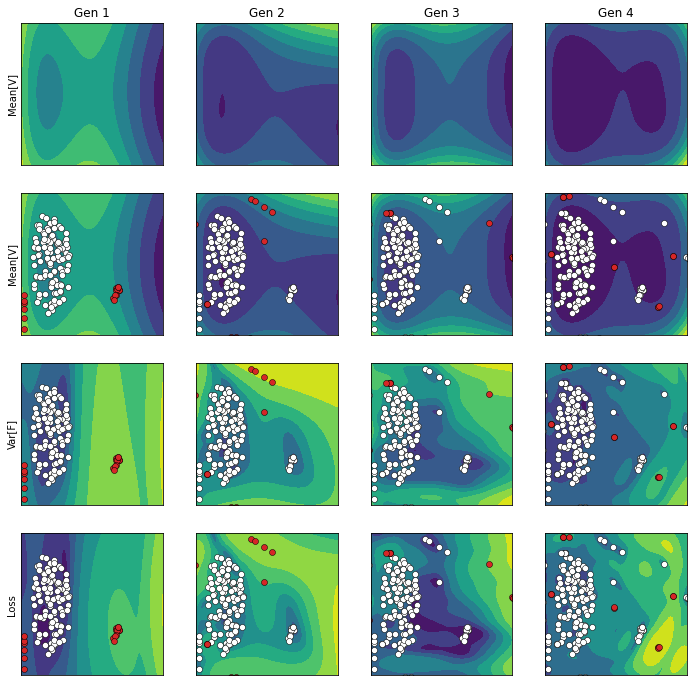

In [ ]:
generations = loop.generations
N_GENS = len(generations)
N_PLOTS = 4
LIMS = np.array([-PLOT_RANGE, PLOT_RANGE])

fig, ax_fig = plt.subplots(N_PLOTS, N_GENS, figsize=(N_GENS * 3, N_PLOTS * 3), sharex=True, sharey=True)

for gen, ax_row in zip(generations, ax_fig.T):
    pipeline = gen['pipeline']
    attacks = gen['attacks']
    attacks_truth = rb.PotentialDataset(*true_potential(attacks.x))

    dplot_model, _, _ = pipeline.evaluate(dplot.get_loader(train_params['batch_size']), DEVICE)
    
    ax = ax_row[0]
    ax.contourf(
        dplot_model.x[:, 0].reshape(SHAPE),
        dplot_model.x[:, 1].reshape(SHAPE),
        dplot_model.e.mean(-1).reshape(SHAPE),
        label='prediction',
        zorder=-1
    )    
    ax.set_aspect('equal')
    ax.set_xlim(LIMS)
    ax.set_ylim(LIMS)
    
    ax = ax_row[1]
    ax.contourf(
        dplot_model.x[:, 0].reshape(SHAPE),
        dplot_model.x[:, 1].reshape(SHAPE),
        dplot_model.e.mean(-1).reshape(SHAPE),
        label='prediction',
        zorder=-1
    )
    ax.scatter(
        pipeline.dset.x[:, 0],
        pipeline.dset.x[:, 1],
        c='w',
        linewidths=0.5,
        edgecolors='k',
        label='training data',
    )
    
    if len(pipeline.dset_train) > 1:
        ax.scatter(
            pipeline.dset_train.x[:, 0],
            pipeline.dset_train.x[:, 1],
            c='w',
            linewidths=0.5,
            edgecolors='k',
            label='training data',
        )

    if len(attacks) > 0:
        ax.scatter(
            attacks_truth.x[:, 0],
            attacks_truth.x[:, 1],
            c='#d62627',
            linewidths=0.5,
            edgecolors='k',
            label='attacks',
        )
    
    ax.set_aspect('equal')
    
    ax.set_xlim(LIMS)
    ax.set_ylim(LIMS)

    ax = ax_row[2]
    ax.contourf(
        dplot_model.x[:, 0].reshape(SHAPE),
        dplot_model.x[:, 1].reshape(SHAPE),
        ch.log(dplot_model.f.var(-1).sum(-1)).reshape(SHAPE),
        label='Var[F]',
        zorder=-1
    )
    ax.scatter(
        pipeline.dset.x[:, 0],
        pipeline.dset.x[:, 1],
        c='w',
        linewidths=0.5,
        edgecolors='k',
        label='training data',
    )
    
    if len(pipeline.dset_train) > 1:
        ax.scatter(
            pipeline.dset_train.x[:, 0],
            pipeline.dset_train.x[:, 1],
            c='w',
            linewidths=0.5,
            edgecolors='k',
            label='training data',
        )
        
    if len(attacks) > 0:
        ax.scatter(
            attacks_truth.x[:, 0],
            attacks_truth.x[:, 1],
            c='#d62627',
            linewidths=0.5,
            edgecolors='k',
            label='attacks',
        )
    
    ax.set_aspect('equal')
    
    ax.set_xlim(LIMS)
    ax.set_ylim(LIMS)
    
    ax = ax_row[3]
    adv_loss = pipeline.get_adv_loss()
    loss = -adv_loss.loss_fn(dplot_model.x, dplot_model.e, dplot_model.f).sum(-1)
    
    ax.contourf(
        dplot_model.x[:, 0].reshape(SHAPE),
        dplot_model.x[:, 1].reshape(SHAPE),
        ch.log(loss).reshape(SHAPE),
        label='loss',
        zorder=-1
    )
    ax.scatter(
        pipeline.dset.x[:, 0],
        pipeline.dset.x[:, 1],
        c='w',
        linewidths=0.5,
        edgecolors='k',
        label='training data',
    )
    
    if len(pipeline.dset_train) > 1:
        ax.scatter(
            pipeline.dset_train.x[:, 0],
            pipeline.dset_train.x[:, 1],
            c='w',
            linewidths=0.5,
            edgecolors='k',
            label='training data',
        )
        
    if len(attacks) > 0:
        ax.scatter(
            attacks_truth.x[:, 0],
            attacks_truth.x[:, 1],
            c='#d62627',
            linewidths=0.5,
            edgecolors='k',
            label='attacks',
        )
    
    ax.set_aspect('equal')
    
    ax.set_xlim(LIMS)
    ax.set_ylim(LIMS)

ax_fig[0, 0].set_ylabel('Mean[V]')
ax_fig[1, 0].set_ylabel('Mean[V]')
ax_fig[2, 0].set_ylabel('Var[F]')
ax_fig[3, 0].set_ylabel('Loss')

for ax, gen in zip(ax_fig[0, :].reshape(-1), generations):
    ax.set_title(f"Gen {gen['generation']}")
    
for ax in ax_fig.reshape(-1):
    ax.spines['right'].set_visible(True)
    ax.spines['top'].set_visible(True)
    ax.set_xticks([])
    ax.set_yticks([])

plt.show()